# Final Project: Predicting Steam Game Prices with Machine Learning
#### Srilasya Ankireddypalle

## Import PySpark

In [1]:
!pip install pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SteamProject") \
    .master("local[*]") \
    .getOrCreate()

spark

## Read in Data

In [2]:
steam_raw = spark.read.option("header", "true") \
                      .option("inferSchema", "true") \
                      .option("multiLine", "true") \
                      .option("escape", '"') \
                      .csv("/content/drive/MyDrive/steam_app_data.csv")

steam_raw.count()

86538

In [3]:
steam_raw.printSchema()

root
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- steam_appid: integer (nullable = true)
 |-- required_age: integer (nullable = true)
 |-- is_free: boolean (nullable = true)
 |-- controller_support: string (nullable = true)
 |-- dlc: string (nullable = true)
 |-- detailed_description: string (nullable = true)
 |-- about_the_game: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- fullgame: string (nullable = true)
 |-- supported_languages: string (nullable = true)
 |-- header_image: string (nullable = true)
 |-- website: string (nullable = true)
 |-- pc_requirements: string (nullable = true)
 |-- mac_requirements: string (nullable = true)
 |-- linux_requirements: string (nullable = true)
 |-- legal_notice: string (nullable = true)
 |-- drm_notice: string (nullable = true)
 |-- ext_user_account_notice: string (nullable = true)
 |-- developers: string (nullable = true)
 |-- publishers: string (nullable = true)
 |-- demos: string

In [4]:
steam_raw.show(5)

+----+--------------------+-----------+------------+-------+------------------+----+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+----------+-----------------------+--------------------+----------+-----+--------------------+------------+--------------------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+------+-----------------+------------+--------------------+--------------------+--------------------+--------------------+
|type|                name|steam_appid|required_age|is_free|controller_support| dlc|detailed_description|      about_the_game|   short_description|fullgame| supported_languages|        header_image|             website|     pc_requirements|    mac_requirements|  linux_requirements|legal_notice|drm_notice|ext_user_account_notice|          d

In [5]:
from pyspark.sql.functions import col, udf, from_json, regexp_replace, sum, when, element_at
from pyspark.sql.types import FloatType, IntegerType, BooleanType, StringType, StructType, ArrayType, StructField
import json

In [6]:
raw_null = steam_raw.select([sum(col(c).isNull().cast("int")).alias(c) for c in steam_raw.columns])
raw_null.show(truncate=False)

+----+----+-----------+------------+-------+------------------+-----+--------------------+--------------+-----------------+--------+-------------------+------------+-------+---------------+----------------+------------------+------------+----------+-----------------------+----------+----------+-----+--------------+--------+--------------+---------+----------+-------+----------+------+-----------+------+---------------+------------+------------+------------+----------+-------------------+
|type|name|steam_appid|required_age|is_free|controller_support|dlc  |detailed_description|about_the_game|short_description|fullgame|supported_languages|header_image|website|pc_requirements|mac_requirements|linux_requirements|legal_notice|drm_notice|ext_user_account_notice|developers|publishers|demos|price_overview|packages|package_groups|platforms|metacritic|reviews|categories|genres|screenshots|movies|recommendations|achievements|release_date|support_info|background|content_descriptors|
+----+----+---

## Clean Data
Drop unneccessary columns, parse json columns, create needed boolean columns.

In [7]:
dropcols = [
    "detailed_description", "about_the_game", "short_description", "fullgame",
    "header_image", "website", "pc_requirements", "mac_requirements", "linux_requirements",
    "legal_notice", "drm_notice", "ext_user_account_notice", "demos", "packages"
    "package_groups", "screenshots", "movies", "support_info", "background", "content_descriptors",
    "controller_support", "dlc", "reviews", "achievements", "metacritic",
    "supported_languages", "packages", "package_groups", "is_free", "release_date"]

steam_clean = steam_raw.drop(*dropcols)

In [8]:
def rec_parse(rec_json):
    try:
        data = json.loads(rec_json.replace("'", "\""))
        return int(data.get("total", 0))
    except:
        return 0

rec_udf = udf(rec_parse, IntegerType())
steam_clean = steam_clean.withColumn("recommendations_count", rec_udf(col("recommendations")))

In [9]:
def gen_parse(gen_json):
    try:
        arr = json.loads(gen_json.replace("'", "\""))
        return [x.get("description","") for x in arr]
    except:
        return []

gen_udf = udf(gen_parse, ArrayType(StringType()))
steam_clean = steam_clean.withColumn("genre_list", gen_udf(col("genres")))

In [10]:
def cat_parse(cat_json):
    try:
        arr = json.loads(cat_json.replace("'", "\""))
        return [x.get("description", "") for x in arr]
    except:
        return []

cat_udf = udf(cat_parse, ArrayType(StringType()))
steam_clean = steam_clean.withColumn("category_list", cat_udf(col("categories")))

In [11]:
def dev_parse(dev_json):
    try:
        arr = json.loads(dev_json.replace("'", "\""))
        return arr   # return list of strings
    except:
        return []

dev_udf = udf(dev_parse, ArrayType(StringType()))
steam_clean = steam_clean.withColumn("developers_list", dev_udf(col("developers")))

In [12]:
def pub_parse(pub_json):
    try:
        return json.loads(pub_json.replace("'", "\""))
    except:
        return []

pub_udf = udf(pub_parse, ArrayType(StringType()))
steam_clean = steam_clean.withColumn("publishers_list", pub_udf(col("publishers")))

In [13]:
steam_clean = steam_clean.withColumn("platforms_json", regexp_replace(col("platforms"), "'", '"'))
steam_clean = steam_clean.withColumn("platforms_json", regexp_replace(col("platforms_json"), "True", "true"))
steam_clean = steam_clean.withColumn("platforms_json", regexp_replace(col("platforms_json"), "False", "false"))

In [14]:
platform_schema = StructType([
    StructField("windows", BooleanType(), True),
    StructField("mac", BooleanType(), True),
    StructField("linux", BooleanType(), True)])

steam_clean = steam_clean.withColumn("platforms_struct", from_json(col("platforms_json"), platform_schema))

In [15]:
steam_clean = steam_clean.withColumn("windows", col("platforms_struct.windows"))
steam_clean = steam_clean.withColumn("mac", col("platforms_struct.mac"))
steam_clean = steam_clean.withColumn("linux", col("platforms_struct.linux"))

In [16]:
price_schema = StructType([
    StructField("currency", StringType(), True),
    StructField("initial", IntegerType(), True),
    StructField("final", IntegerType(), True)])

steam_clean = steam_clean.withColumn("price_struct", from_json(col("price_overview"), price_schema))
steam_clean = steam_clean.withColumn("price_final", col("price_struct.final") / 100)

In [17]:
steam_clean = steam_clean.drop("platforms", "platforms_json", "platforms_struct", "price_overview",
                               "recommendations", "is_free", "developers", "publishers",
                               "categories", "genres", "price_struct")

In [18]:
steam_clean = steam_clean.filter(col("price_final").isNotNull())

In [19]:
clean_null = steam_clean.select([sum(col(c).isNull().cast("int")).alias(c) for c in steam_clean.columns])
clean_null.show(truncate=False)

+----+----+-----------+------------+---------------------+----------+-------------+---------------+---------------+-------+---+-----+-----------+
|type|name|steam_appid|required_age|recommendations_count|genre_list|category_list|developers_list|publishers_list|windows|mac|linux|price_final|
+----+----+-----------+------------+---------------------+----------+-------------+---------------+---------------+-------+---+-----+-----------+
|0   |0   |0          |0           |0                    |0         |0            |0              |0              |0      |0  |0    |0          |
+----+----+-----------+------------+---------------------+----------+-------------+---------------+---------------+-------+---+-----+-----------+



In [20]:
steam_clean.count()

74554

In [21]:
steam_clean.show(5)

+----+--------------------+-----------+------------+---------------------+----------+--------------------+------------------+---------------+-------+----+-----+-----------+
|type|                name|steam_appid|required_age|recommendations_count|genre_list|       category_list|   developers_list|publishers_list|windows| mac|linux|price_final|
+----+--------------------+-----------+------------+---------------------+----------+--------------------+------------------+---------------+-------+----+-----+-----------+
|game|      Counter-Strike|         10|           0|               162153|  [Action]|[Multi-player, Pv...|           [Valve]|        [Valve]|   true|true| true|       8.19|
|game|Team Fortress Cla...|         20|           0|                 6647|  [Action]|[Multi-player, Pv...|           [Valve]|        [Valve]|   true|true| true|      16.99|
|game|       Day of Defeat|         30|           0|                 4318|  [Action]|[Multi-player, Ca...|           [Valve]|        [V

In [22]:
from pyspark.ml.feature import CountVectorizer, StringIndexer, OneHotEncoder, VectorAssembler
import matplotlib.pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

## Make Data ML Ready

In [23]:
# convert t/f to 1/0
steam_ml = steam_clean \
    .withColumn("windows", col("windows").cast("double")) \
    .withColumn("mac", col("mac").cast("double")) \
    .withColumn("linux", col("linux").cast("double"))

In [24]:
# turn genre/category lists into numeric vectors
genre_vectorizer = CountVectorizer(inputCol="genre_list", outputCol="genre_features")
category_vectorizer = CountVectorizer(inputCol="category_list", outputCol="category_features")

steam_ml = genre_vectorizer.fit(steam_ml).transform(steam_ml)
steam_ml = category_vectorizer.fit(steam_ml).transform(steam_ml)

In [25]:
# find primary developer/publisher and turn into numeric value
steam_ml = steam_ml.withColumn("developer_primary", element_at(col("developers_list"), 1))
steam_ml = steam_ml.withColumn("publisher_primary", element_at(col("publishers_list"), 1))

dev_indexer = StringIndexer(inputCol="developer_primary", outputCol="developer_index", handleInvalid="keep")
dev_encoder = OneHotEncoder(inputCol="developer_index", outputCol="developer_features")
pub_indexer = StringIndexer(inputCol="publisher_primary", outputCol="publisher_index", handleInvalid="keep")
pub_encoder = OneHotEncoder(inputCol="publisher_index", outputCol="publisher_features")

steam_ml = dev_indexer.fit(steam_ml).transform(steam_ml)
steam_ml = dev_encoder.fit(steam_ml).transform(steam_ml)
steam_ml = pub_indexer.fit(steam_ml).transform(steam_ml)
steam_ml = pub_encoder.fit(steam_ml).transform(steam_ml)

In [26]:
steam_ml = steam_ml.filter((col("price_final") > 0) & (col("price_final") < 200))

In [27]:
steam_ml.count()

74067

## Athena Schema:

In [32]:
steam_ml.printSchema()

root
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- steam_appid: integer (nullable = true)
 |-- required_age: integer (nullable = true)
 |-- recommendations_count: integer (nullable = true)
 |-- genre_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- category_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- developers_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- publishers_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- windows: double (nullable = true)
 |-- mac: double (nullable = true)
 |-- linux: double (nullable = true)
 |-- price_final: double (nullable = true)
 |-- genre_features: vector (nullable = true)
 |-- category_features: vector (nullable = true)
 |-- developer_primary: string (nullable = true)
 |-- publisher_primary: string (nullable = true)
 |-- developer_index: double (nullable = false)
 |-- developer_f

In [35]:
'''
CREATE EXTERNAL TABLE IF NOT EXISTS steam_ml_schema (
    type STRING,
    name STRING,
    steam_appid INT,
    required_age INT,
    recommendations_count INT,

    genre_list ARRAY<STRING>,
    category_list ARRAY<STRING>,
    developers_list ARRAY<STRING>,
    publishers_list ARRAY<STRING>,

    windows DOUBLE,
    mac DOUBLE,
    linux DOUBLE,
    price_final DOUBLE,

    developer_primary STRING,
    publisher_primary STRING,
    developer_index DOUBLE,
    publisher_index DOUBLE,

    genre_features STRING,
    category_features STRING,
    developer_features STRING,
    publisher_features STRING,
    features STRING
)
STORED AS PARQUET
LOCATION 's3://csc555-bucket/steam-project/'
'''

" Athena Schema Creation:\nCREATE EXTERNAL TABLE IF NOT EXISTS steam_ml_schema (\n    type STRING,\n    name STRING,\n    steam_appid INT,\n    required_age INT,\n    recommendations_count INT,\n\n    genre_list ARRAY<STRING>,\n    category_list ARRAY<STRING>,\n    developers_list ARRAY<STRING>,\n    publishers_list ARRAY<STRING>,\n\n    windows DOUBLE,\n    mac DOUBLE,\n    linux DOUBLE,\n    price_final DOUBLE,\n\n    developer_primary STRING,\n    publisher_primary STRING,\n    developer_index DOUBLE,\n    publisher_index DOUBLE,\n\n    genre_features STRING,\n    category_features STRING,\n    developer_features STRING,\n    publisher_features STRING,\n    features STRING\n)\nSTORED AS PARQUET\nLOCATION 's3://csc555-bucket/steam-project/'\n"

## Target Variable Distribution

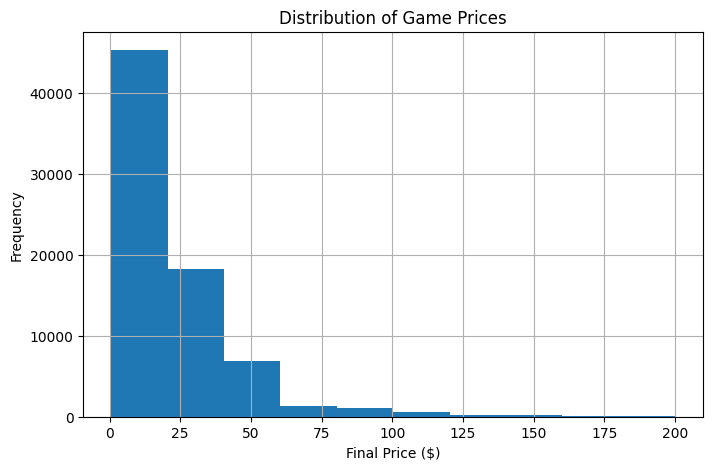

In [28]:
# price_final histogram
price_pd = steam_ml.select("price_final").toPandas()

plt.figure(figsize=(8,5))
plt.hist(price_pd["price_final"], bins=10)
plt.xlabel("Final Price ($)")
plt.ylabel("Frequency")
plt.title("Distribution of Game Prices")
plt.grid(True)
plt.show()

In [29]:
assembler = VectorAssembler(
    inputCols=[
        "required_age",
        "recommendations_count",
        "windows", "mac", "linux",
        "genre_features",
        "category_features",
        "developer_features",
        "publisher_features"],
    outputCol="features")

steam_ml = assembler.transform(steam_ml)

train, test = steam_ml.randomSplit([0.8, 0.2], seed=123)

## Run ML Model and Visualize

In [30]:
lr = LinearRegression(
    featuresCol="features",
    labelCol="price_final",
    elasticNetParam=0.3,    # mix of L1/L2 regularization
    regParam=0.1,           # adjust regularization strength
    maxIter=100)

lr_model = lr.fit(train)
pred_lr = lr_model.transform(test)

evaluator_rmse = RegressionEvaluator(labelCol="price_final", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="price_final", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(pred_lr)
r2 = evaluator_r2.evaluate(pred_lr)

print("Linear Regression RMSE:", rmse)
print("Linear Regression R2:", r2)

Linear Regression RMSE: 16.98459531135
Linear Regression R2: 0.437030287557992


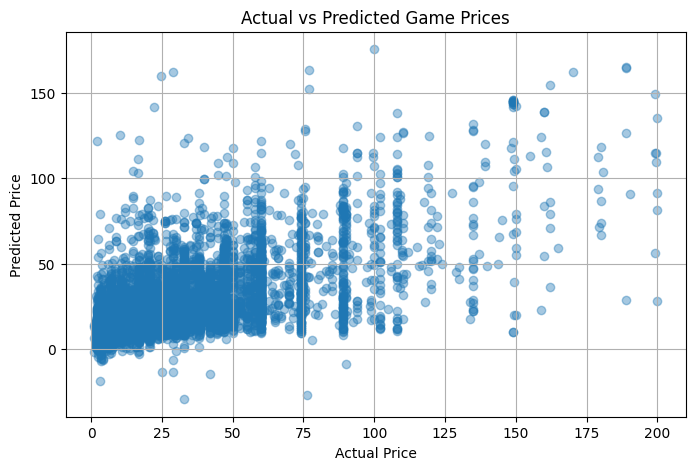

In [31]:
pred_pd = pred_lr.select("price_final", "prediction").toPandas()

plt.figure(figsize=(8,5))
plt.scatter(pred_pd["price_final"], pred_pd["prediction"], alpha=0.4)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Game Prices")
plt.grid(True)
plt.show()